In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "facebook-metrics"

# Predicting the likes of Facebook Posts for a cosmetics company.

# Introduction 

Social media has increasingly become the most powerful platform for companies and brands to promote their businesses and influence customers. A system able to predict the impact of individual published posts can provide a valuable advantage when deciding to communicate through social media, tailoring the promotion of products and services. Brands can then make informed decisions based on receptiveness of the  published posts and predictions and thus, develop strategies toward optimizing the impact of posts (Moro et al., 2016) as it has been shown that social media publications are highly related to brand building (Edosomwan et al., 2011). 
 
This project seeks to answer the question of predicting the number of likes on a photograph posted on a cosmetics brand’s page using total interactions, lifetime post consumers and likes as the predictors? To answer the question, the dataset that will be used is related to posts published during the year of 2014 on the brand’s Facebook page. It contains 500 of the total 790 posts published and part of the features analyzed by Moro et al. (2016). The remaining were omitted due to confidentiality issues. It should be noted that Facebook was the most used social network with an average of 1.28 billion monthly active users in 2014 (Insights, 2014). The data set compiled contains four types of features: 

1. Identification — features that allow identifying each individual post 
2. Content — the textual content of the post 
3. Categorization — features that characterize the post 
4. Performance — metrics for measuring the impact of the post (or the impact of the page, in the case of “Page total likes”) 

> The following Table from Moro et al., details what the columns within the dataset encompass.

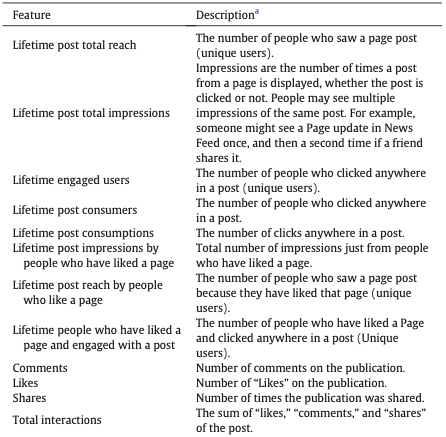

# Methodology
Firstly, all of the required libraries are collectively loaded at the beginning of the code. The following code will thus use functions from these libraries. 

In [2]:
library(tidyverse)
library(rvest)
library(stringr)
library(repr)
library(corrplot)
library(tidyverse)
library(forcats)
library(tidymodels)

Loading required package: xml2


Attaching package: ‘rvest’


The following object is masked from ‘package:purrr’:

    pluck


The following object is masked from ‘package:readr’:

    guess_encoding


corrplot 0.84 loaded

── Attaching packages ────────────────────────────────────── tidymodels 0.1.2 ──

✔ broom     0.7.5      ✔ recipes   0.1.15
✔ dials     0.0.9      ✔ rsample   0.0.9 
✔ infer     0.5.4      ✔ tune      0.1.3 
✔ modeldata 0.1.0      ✔ workflows 0.2.2 
✔ parsnip   0.1.5      ✔ yardstick 0.0.7 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ rvest::pluck()    masks purrr::pluck()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()



Then, the data is read from the original source on the web after identifying that the dataset uses a semicolon as the separator from opening the data using a text reader. The rows with NA are then omitted to remove data points which will not have the necessary values.

In [3]:
facebook_metrics <- read_delim("../input/facebook-metrics/dataset_Facebook.csv",delim=";") 
facebook_metrics <-  na.omit(facebook_metrics) 


── Column specification ────────────────────────────────────────────────────────
cols(
  `Page total likes` = col_double(),
  Type = col_character(),
  Category = col_double(),
  `Post Month` = col_double(),
  `Post Weekday` = col_double(),
  `Post Hour` = col_double(),
  Paid = col_double(),
  `Lifetime Post Total Reach` = col_double(),
  `Lifetime Post Total Impressions` = col_double(),
  `Lifetime Engaged Users` = col_double(),
  `Lifetime Post Consumers` = col_double(),
  `Lifetime Post Consumptions` = col_double(),
  `Lifetime Post Impressions by people who have liked your Page` = col_double(),
  `Lifetime Post reach by people who like your Page` = col_double(),
  `Lifetime People who have liked your Page and engaged with your post` = col_double(),
  comment = col_double(),
  like = col_double(),
  share = col_double(),
  `Total Interactions` = col_double()
)




**Data Exploratory Analysis and preliminary wrangling**

The structure function is used to identify the basic internal structure in a summarized form.

In [4]:
str(facebook_metrics)

tibble [495 × 19] (S3: tbl_df/tbl/data.frame)
 $ Page total likes                                                   : num [1:495] 139441 139441 139441 139441 139441 ...
 $ Type                                                               : chr [1:495] "Photo" "Status" "Photo" "Photo" ...
 $ Category                                                           : num [1:495] 2 2 3 2 2 2 3 3 2 3 ...
 $ Post Month                                                         : num [1:495] 12 12 12 12 12 12 12 12 12 12 ...
 $ Post Weekday                                                       : num [1:495] 4 3 3 2 2 1 1 7 7 6 ...
 $ Post Hour                                                          : num [1:495] 3 10 3 10 3 9 3 9 3 10 ...
 $ Paid                                                               : num [1:495] 0 0 0 1 0 0 1 1 0 0 ...
 $ Lifetime Post Total Reach                                          : num [1:495] 2752 10460 2413 50128 7244 ...
 $ Lifetime Post Total Impressions        

The rows in Category are then renamed from 1,2,3 to Action, Product, and Inspiration. These are the correct manually added names from Moro et al (2016). The Paid rows which were initially 0, which corresponded to not paid, has also been replaced with -1 to make finding the total number of each type of post easier to calculate.

In [5]:
colnames(facebook_metrics) <- make.names(colnames(facebook_metrics))
facebook_metrics$Category[facebook_metrics$Category == 1] <- "Action"
facebook_metrics$Category[facebook_metrics$Category == 2] <- "Product"
facebook_metrics$Category[facebook_metrics$Category == 3] <- "Inspiration"
facebook_metrics$Paid[facebook_metrics$Paid == 0] <- -1

The total number of each type of post is then calculated in order to identify whether there is a large enough split to choose just one of the two types of posts. The Paid and not-Paid data has been seen to have significantly different numbers of engagement which would skew any model created from the rows of data encompassing both. The not paid has 356 points which we considered sufficient enough to create a model.

In [6]:
facebook_metrics_paid <- facebook_metrics %>% group_by(Paid)  %>% summarize(n = n())
facebook_metrics_paid

Paid,n
<dbl>,<int>
-1,356
1,139


A cross analysis using the ggpairs function is further run to identify those functions with correlations to select predictors excluding those colums with discrete data. The plot size are arbritarily set for this visualization and for following visualizations.

Loading required package: GGally

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



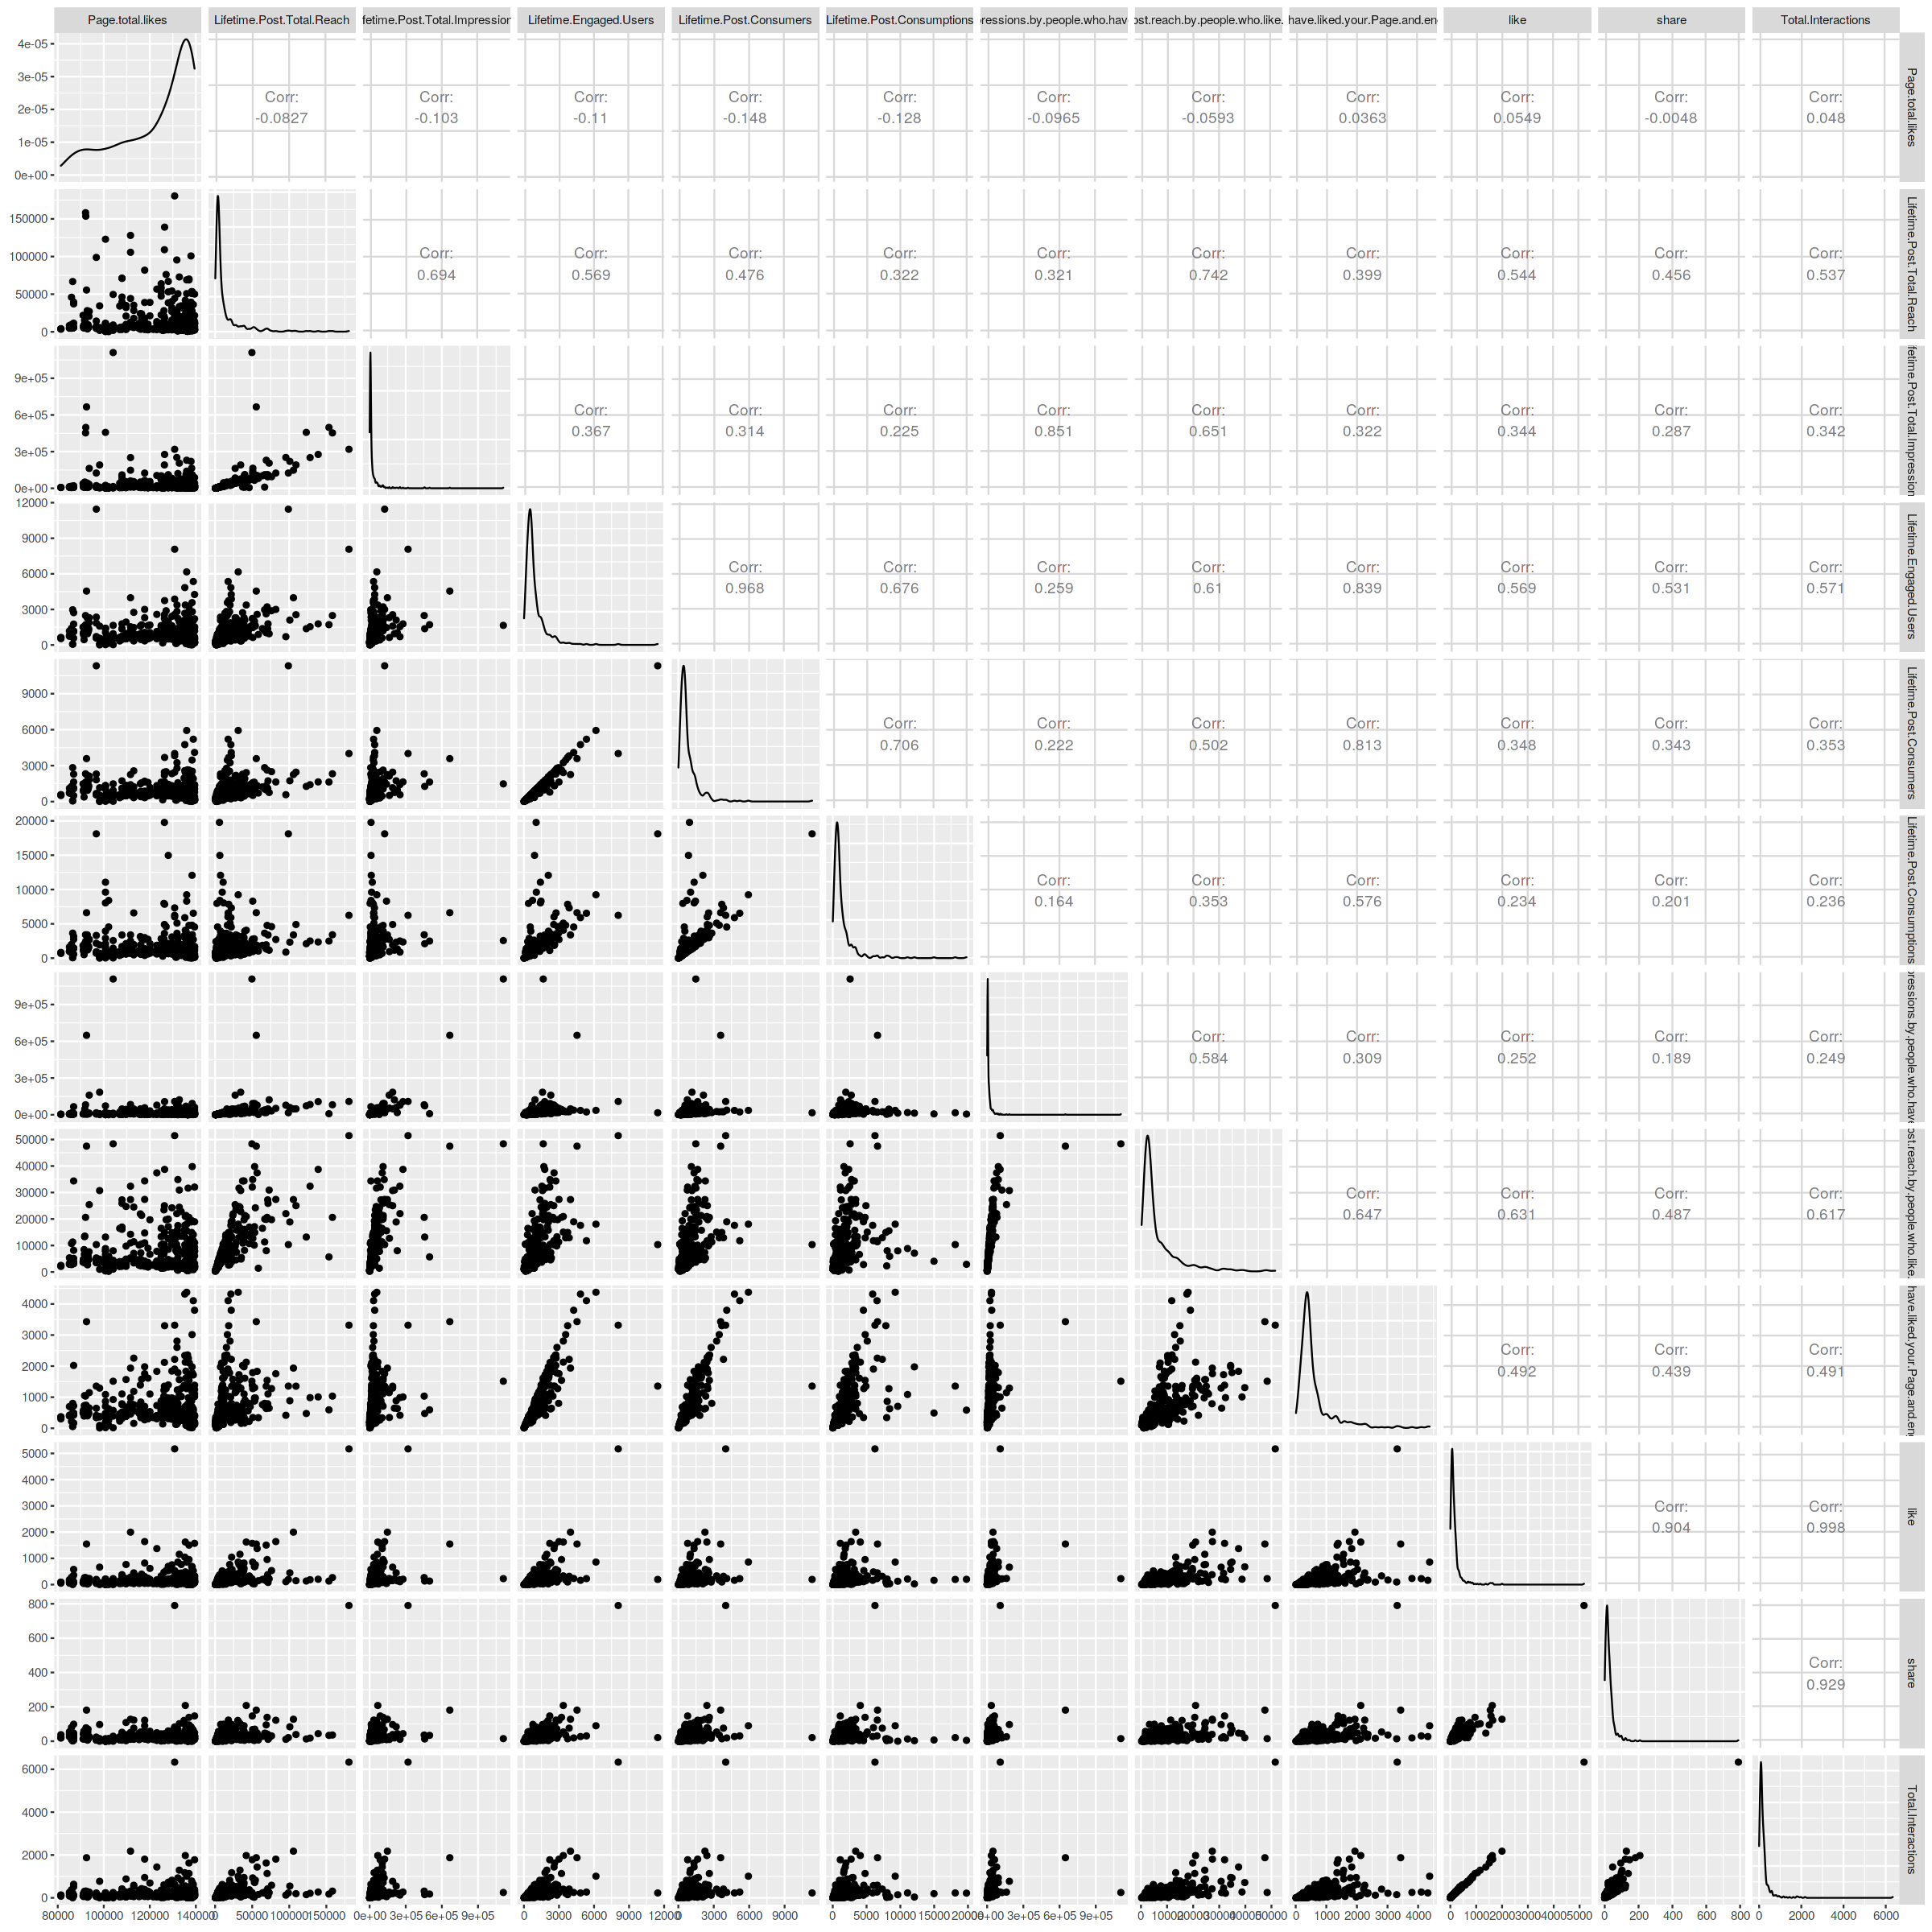

In [7]:
options(repr.plot.width = 20, repr.plot.height = 20)
require(GGally)
facebook_metrics_select <- select(facebook_metrics, -comment, -Post.Month, -Post.Weekday, -Post.Hour, -Category, -Type, -Paid)
ggpairs(facebook_metrics_select, lower=list(combo=wrap("facethist", binwidth=0.8)))

The data is further then explored using the selected stuff functions which up-samples the data to first ensure that all of the Categories have equal numbers of points for ease of manual analysis. The group functions are then used to identify whether using both Paid and not data vs only not paid data has an effect on the intended predictors’ values. It is observed that data has less skewing if only not paid data is used as paid posts tend to have a higher number of likes and engagements due to how Facebook’s algorithm operate.

In [8]:
selected_stuff <- filter(select(facebook_metrics,Category,Total.Interactions,Lifetime.Post.Total.Reach,Lifetime.Post.Consumers,Page.total.likes, Paid), Paid == -1)
selected_stuff_1 <- select(facebook_metrics,Category,Total.Interactions,Lifetime.Post.Total.Reach,Lifetime.Post.Consumers,Page.total.likes, Paid)
upsampled_fb <- recipe(Category ~ ., data = selected_stuff) %>%
  themis::step_upsample(Category, over_ratio = 1, skip = FALSE) %>%
  prep() %>%
  bake(selected_stuff)

facebook_metrics_cat <- upsampled_fb %>% group_by(Category)  %>% summarize(n = n())
facebook_metrics_cat


group <- upsampled_fb %>% 
  group_by(Category) %>% 
  summarise(across(everything(), sum))

upsampled_fb_1 <- recipe(Category ~ ., data = selected_stuff_1) %>%
  themis::step_upsample(Category, over_ratio = 1, skip = FALSE) %>%
  prep() %>%
  bake(selected_stuff_1)

group_1 <- upsampled_fb_1 %>% 
  group_by(Category) %>% 
  summarise(across(everything(), sum))
group_1
group

Registered S3 methods overwritten by 'themis':
  method               from   
  bake.step_downsample recipes
  bake.step_upsample   recipes
  prep.step_downsample recipes
  prep.step_upsample   recipes
  tidy.step_downsample recipes
  tidy.step_upsample   recipes



Category,n
<fct>,<int>
Action,147
Inspiration,147
Product,147


Category,Total.Interactions,Lifetime.Post.Total.Reach,Lifetime.Post.Consumers,Page.total.likes,Paid
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Action,31898,3935429,164201,25902419,-83
Inspiration,54504,2140699,135086,25238117,-101
Product,64900,2382765,216752,27494484,-123


Category,Total.Interactions,Lifetime.Post.Total.Reach,Lifetime.Post.Consumers,Page.total.likes,Paid
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Action,20614,2352467,100937,17953662,-147
Inspiration,35448,1965124,109207,17240982,-147
Product,25435,1093161,137551,18985572,-147


**Model Creation**

To make the split reproducible, set.seed function has been used. 75:25 training:testing split is used as the dataset is less than 400 points for the data set with only non-paid posts. Thus, it would be the optimal amount of data for training and testing purposes while maximizing accuracy.

In [9]:
set.seed(123)

facebook_metrics_split <- facebook_metrics %>% initial_split(prop = 0.75, strata = like)  
facebook_metrics_train <- training(facebook_metrics_split)   
facebook_metrics_test <- testing(facebook_metrics_split)

The columns were selected from the dataset to be used for the analysis as these were the columns with continuous values without overlapping data sets according to Moro et al (2016). 
They are then used for the correlation plot function. The columns are specifically selected from the training data to ensure that the model won’t see the training data in any of the steps to create it. The functions used are from the corrplot library in order to specifically identify the correlation between the columns. The cor function creates a table of data with the correlation values while the corrplot creates a visualization using the square method for easy viewability. 

,Lifetime.Post.Total.Reach,Lifetime.Post.Consumers,Lifetime.Post.Total.Impressions,Lifetime.Engaged.Users,Page.total.likes,Total.Interactions,like
Lifetime.Post.Total.Reach,1.0000000,0.4285275,0.6644491,0.5059286,-0.11191156,0.4803843,0.48318705
Lifetime.Post.Consumers,0.4285275,1.0000000,0.3206588,0.9714745,-0.15859851,0.4225745,0.40642193
Lifetime.Post.Total.Impressions,0.6644491,0.3206588,1.0000000,0.3632812,-0.12834669,0.3304609,0.32461598
Lifetime.Engaged.Users,0.5059286,0.9714745,0.3632812,1.0000000,-0.12342877,0.6183704,0.60699832
Page.total.likes,-0.1119116,-0.1585985,-0.1283467,-0.1234288,1.00000000,0.0345879,0.04046534
Total.Interactions,0.4803843,0.4225745,0.3304609,0.6183704,0.03458790,1.0000000,0.99763299
like,0.4831870,0.4064219,0.3246160,0.6069983,0.04046534,0.9976330,1.00000000


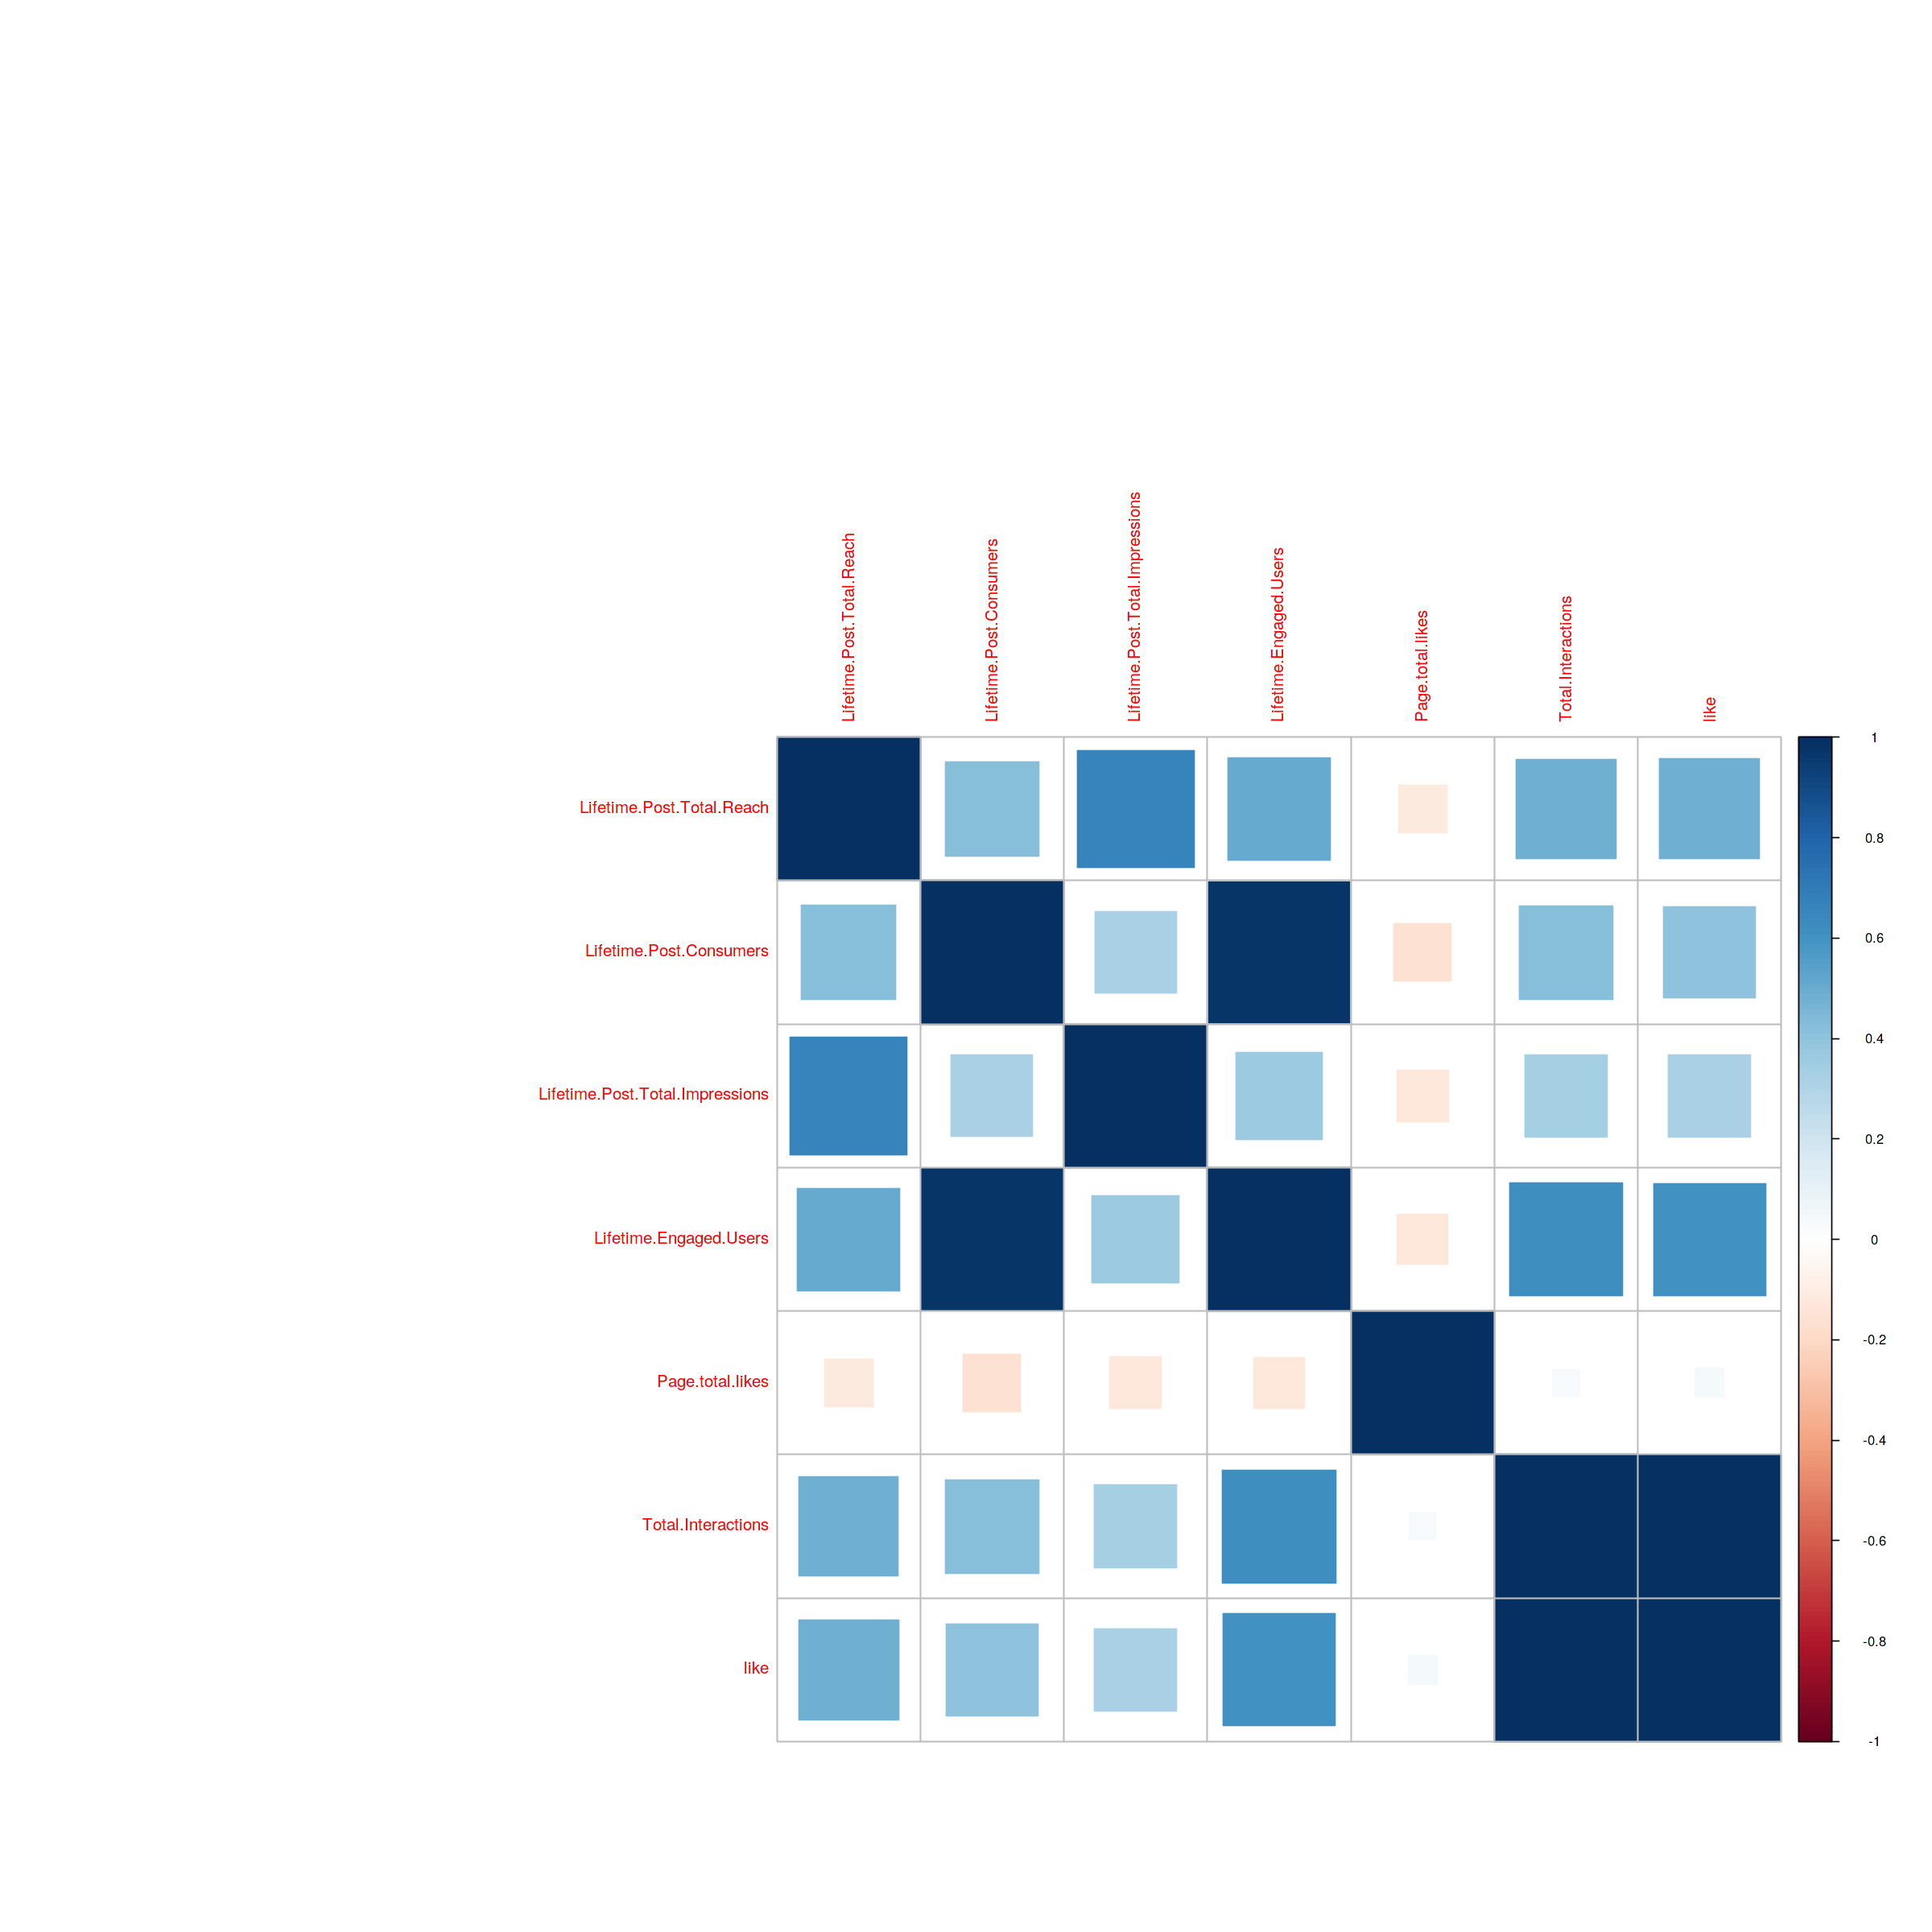

In [10]:
options(repr.plot.width = 20, repr.plot.height = 20)
corr_select <- select(facebook_metrics_train,Lifetime.Post.Total.Reach,Lifetime.Post.Consumers,Lifetime.Post.Total.Impressions,Lifetime.Engaged.Users,Lifetime.Post.Consumers,Page.total.likes,Total.Interactions,like)
corr_facebook <- cor(corr_select)
corrplot(corr_facebook, method = "square")
corr_facebook

The visualization is used to identify the Variance Intensity Factor to reduce the effects of multicollinearity (Wu, 2020). The predictors were thus chosen for the model recipes based on their lack of significant correlation based on the color and size of the square. This ensures that a change to one predictor does not affect another predictor and produce significant changes to the predicted value.

**K-nearest neighbour Model**

Another set.seed function is used in order to make the v_fold function and the model as a whole reproducible. An object has then been created using filter and select with only the relevant columns selected for analysis in addition to only not paid rows. The v_fold function is then used to create 10 folds for cross validation and k-nn model tuning. 10 was seen to have the greatest payoff in terms of accuracy and time taken in the trials with 5, 10, and 20 folds. 
A specification for the model is then created with neighbours set to tune for model tuning.
Gridvals is used to set a minimum and maximum number of K values to test for and fifty was chosen as the maximum. A K larger than fifty would likely cause the model to be useless considering the number of points in the data splits. 
The recipe is created with the predictors being scaled and centered to standardize the means and standard deviations thus preventing any single predictors from affecting the prediction more strongly. 
A workflow is then created using the knn_recipe and knn_spec previously created. It is later used to collect metrics to find the K values with the smallest prediction error using the min function.
 
*K = 14* is identified using tuning.

In [11]:
set.seed(12345)
analysis_select <- filter(select(facebook_metrics_train,Paid,Lifetime.Post.Total.Impressions,Lifetime.Post.Consumers,Lifetime.Post.Total.Reach,Page.total.likes,like), Paid == -1)

facebook_vfold <- vfold_cv(analysis_select,v= 10, strata = like)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("regression")

gridvals <- tibble(neighbors = seq(1,50))

knn_recipe <- recipe(like ~  Lifetime.Post.Total.Reach + Lifetime.Post.Total.Impressions + Page.total.likes, data = analysis_select) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_wkflw <- workflow() %>%
  add_recipe(knn_recipe) %>%
  add_model(knn_spec) 

knn_results <- knn_wkflw %>%
  tune_grid(resamples = facebook_vfold, grid = gridvals) %>%
  collect_metrics()

knn_results

knn_min <- knn_results %>%
  filter(.metric == "rmse") %>%
  filter(mean == min(mean))
knn_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<fct>
1,rmse,standard,239.8674993,10,33.32710807,Preprocessor1_Model01
1,rsq,standard,0.2053226,10,0.05551606,Preprocessor1_Model01
2,rmse,standard,226.7123420,10,27.90634126,Preprocessor1_Model02
2,rsq,standard,0.2618690,10,0.06487331,Preprocessor1_Model02
3,rmse,standard,216.8589826,10,21.34626184,Preprocessor1_Model03
3,rsq,standard,0.3415437,10,0.07354620,Preprocessor1_Model03
4,rmse,standard,206.4586554,10,20.53580717,Preprocessor1_Model04
4,rsq,standard,0.3544761,10,0.07641444,Preprocessor1_Model04
5,rmse,standard,198.4872873,10,19.82177215,Preprocessor1_Model05


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<fct>
14,rmse,standard,181.3796,10,13.60908,Preprocessor1_Model14


The above model creation steps are repeated with neighbours being fit to the minimum K values identified and thus creating a new knn_k_spec. A metrics summary is then created of the knn_fit model being tested against the testing data split with the columns then being bound to the data set. A prediction is then then done of the entire dataset for the following visualizations

In [12]:
kmin <- knn_min %>% pull(neighbors)
knn_k_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) %>%
  set_engine("kknn") %>%
  set_mode("regression")

knn_fit <- workflow() %>%
  add_recipe(knn_recipe) %>%
  add_model(knn_k_spec) %>%
  fit(data = analysis_select)

knn_summary <- knn_fit %>%
  predict(facebook_metrics_test) %>%
  bind_cols(facebook_metrics_test) %>%
  metrics(truth = like, estimate = .pred)

knn_summary

knn_preds <- knn_fit %>%
  predict(analysis_select) %>%
  bind_cols(analysis_select)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,439.6255427
rsq,standard,0.1420009
mae,standard,123.9947307


Three scatter graphs with overlying line graphs are then plotted - lifetime post total reach, lifetime post consumers and page total likes vs. likes. This is to see the relationship between the variables. We make sure that the points can be seen individually by setting the alpha argument in geom_point to 0.4 to make the dots slightly translucent. The line is similarly set to be blue while the axes and graphs have been given human readable titles. The log10 scale enables the axes to be transformed to an appropriate scale so the points are spread out and individually identifiable as well while. 


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


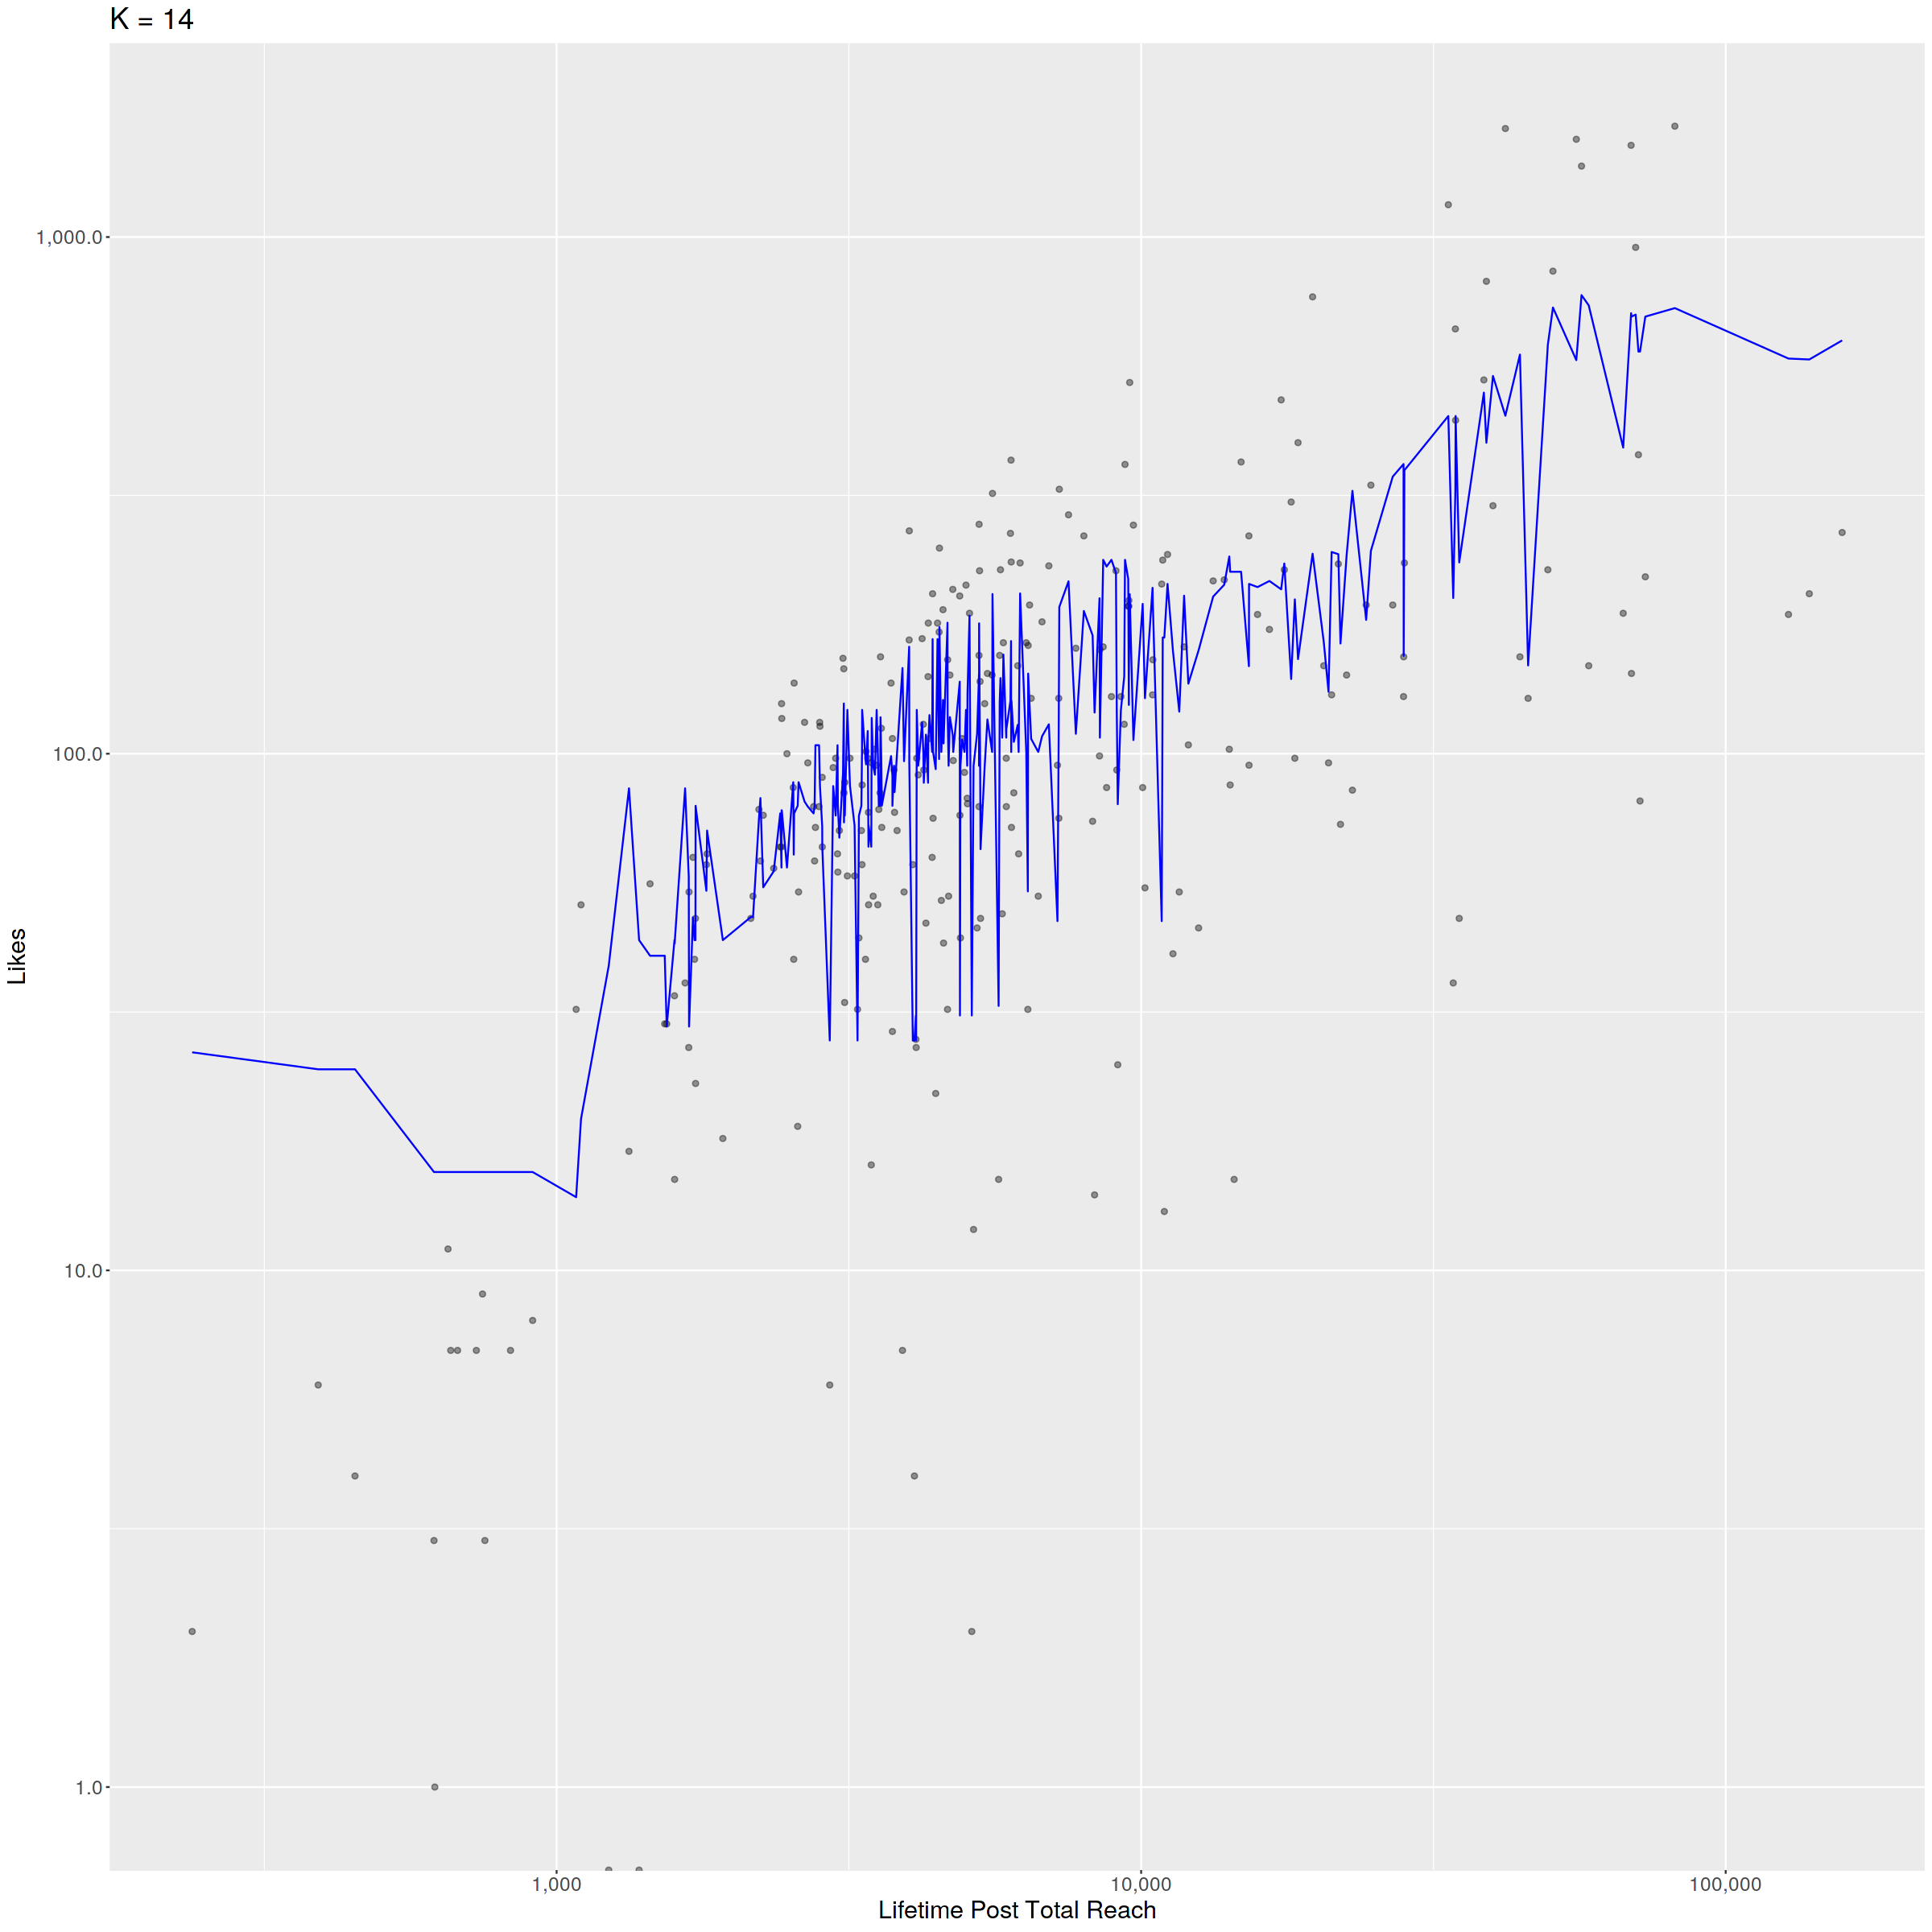

Warning message:
“Transformation introduced infinite values in continuous y-axis”


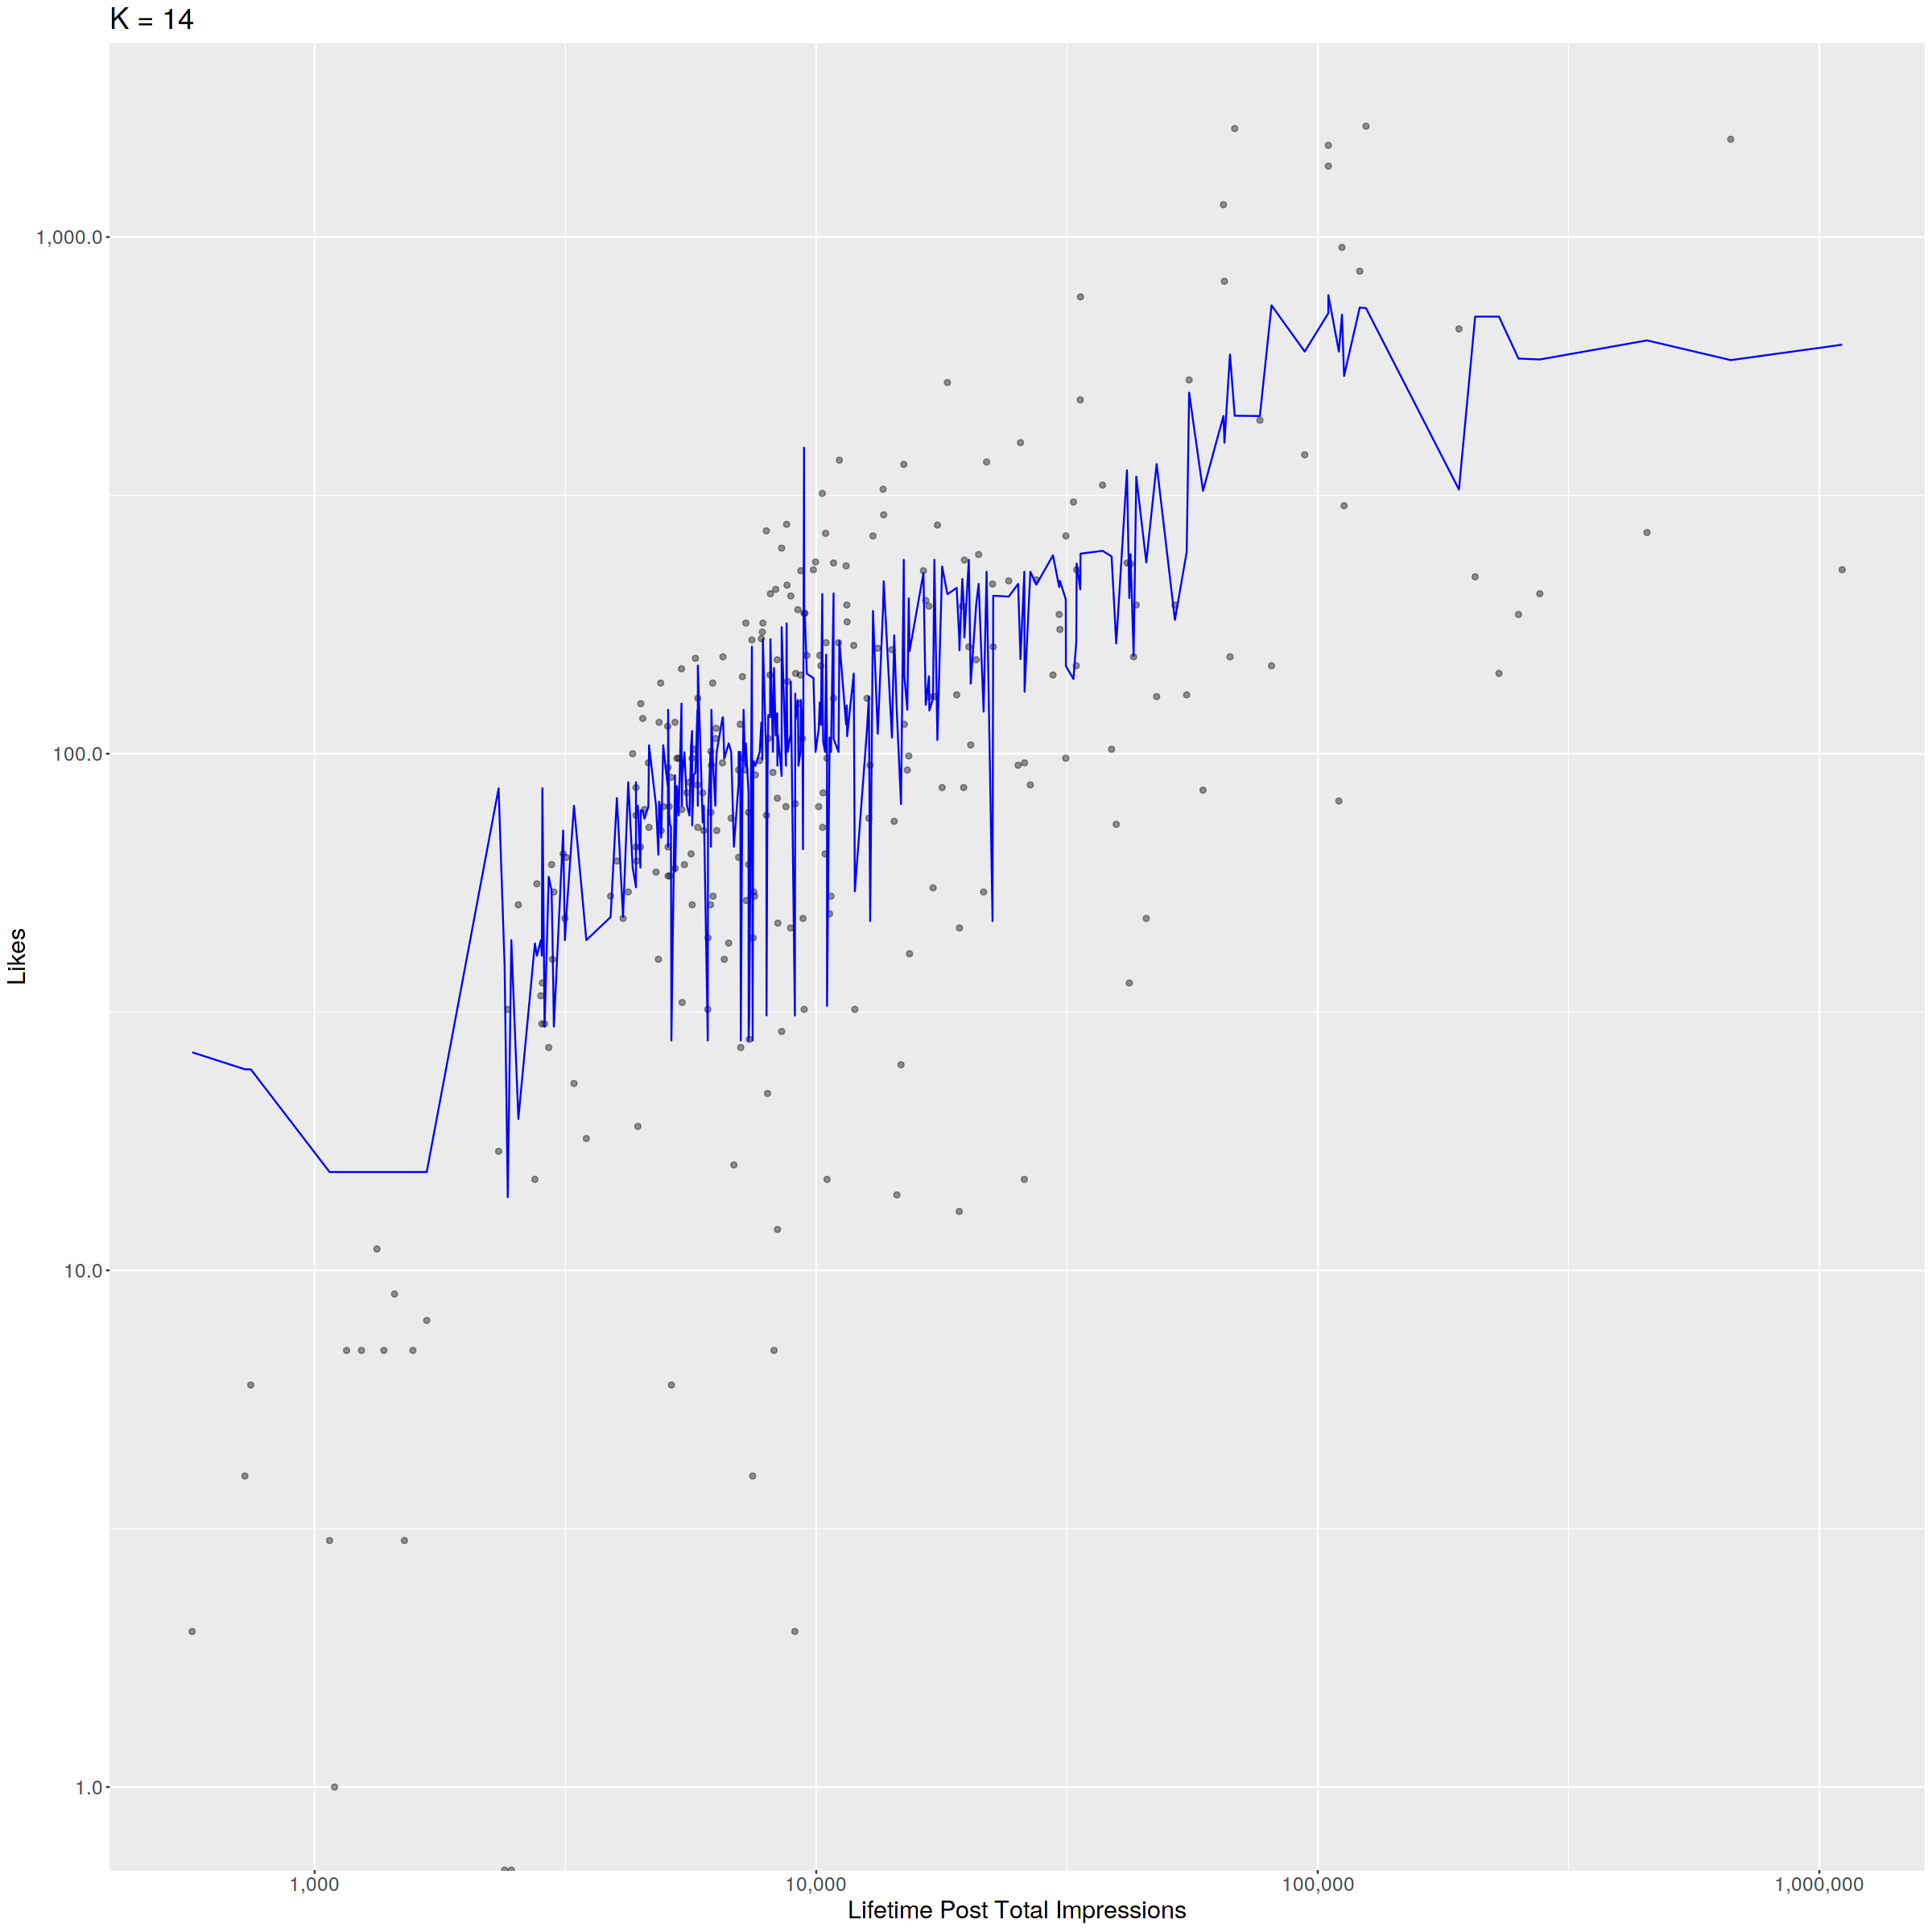

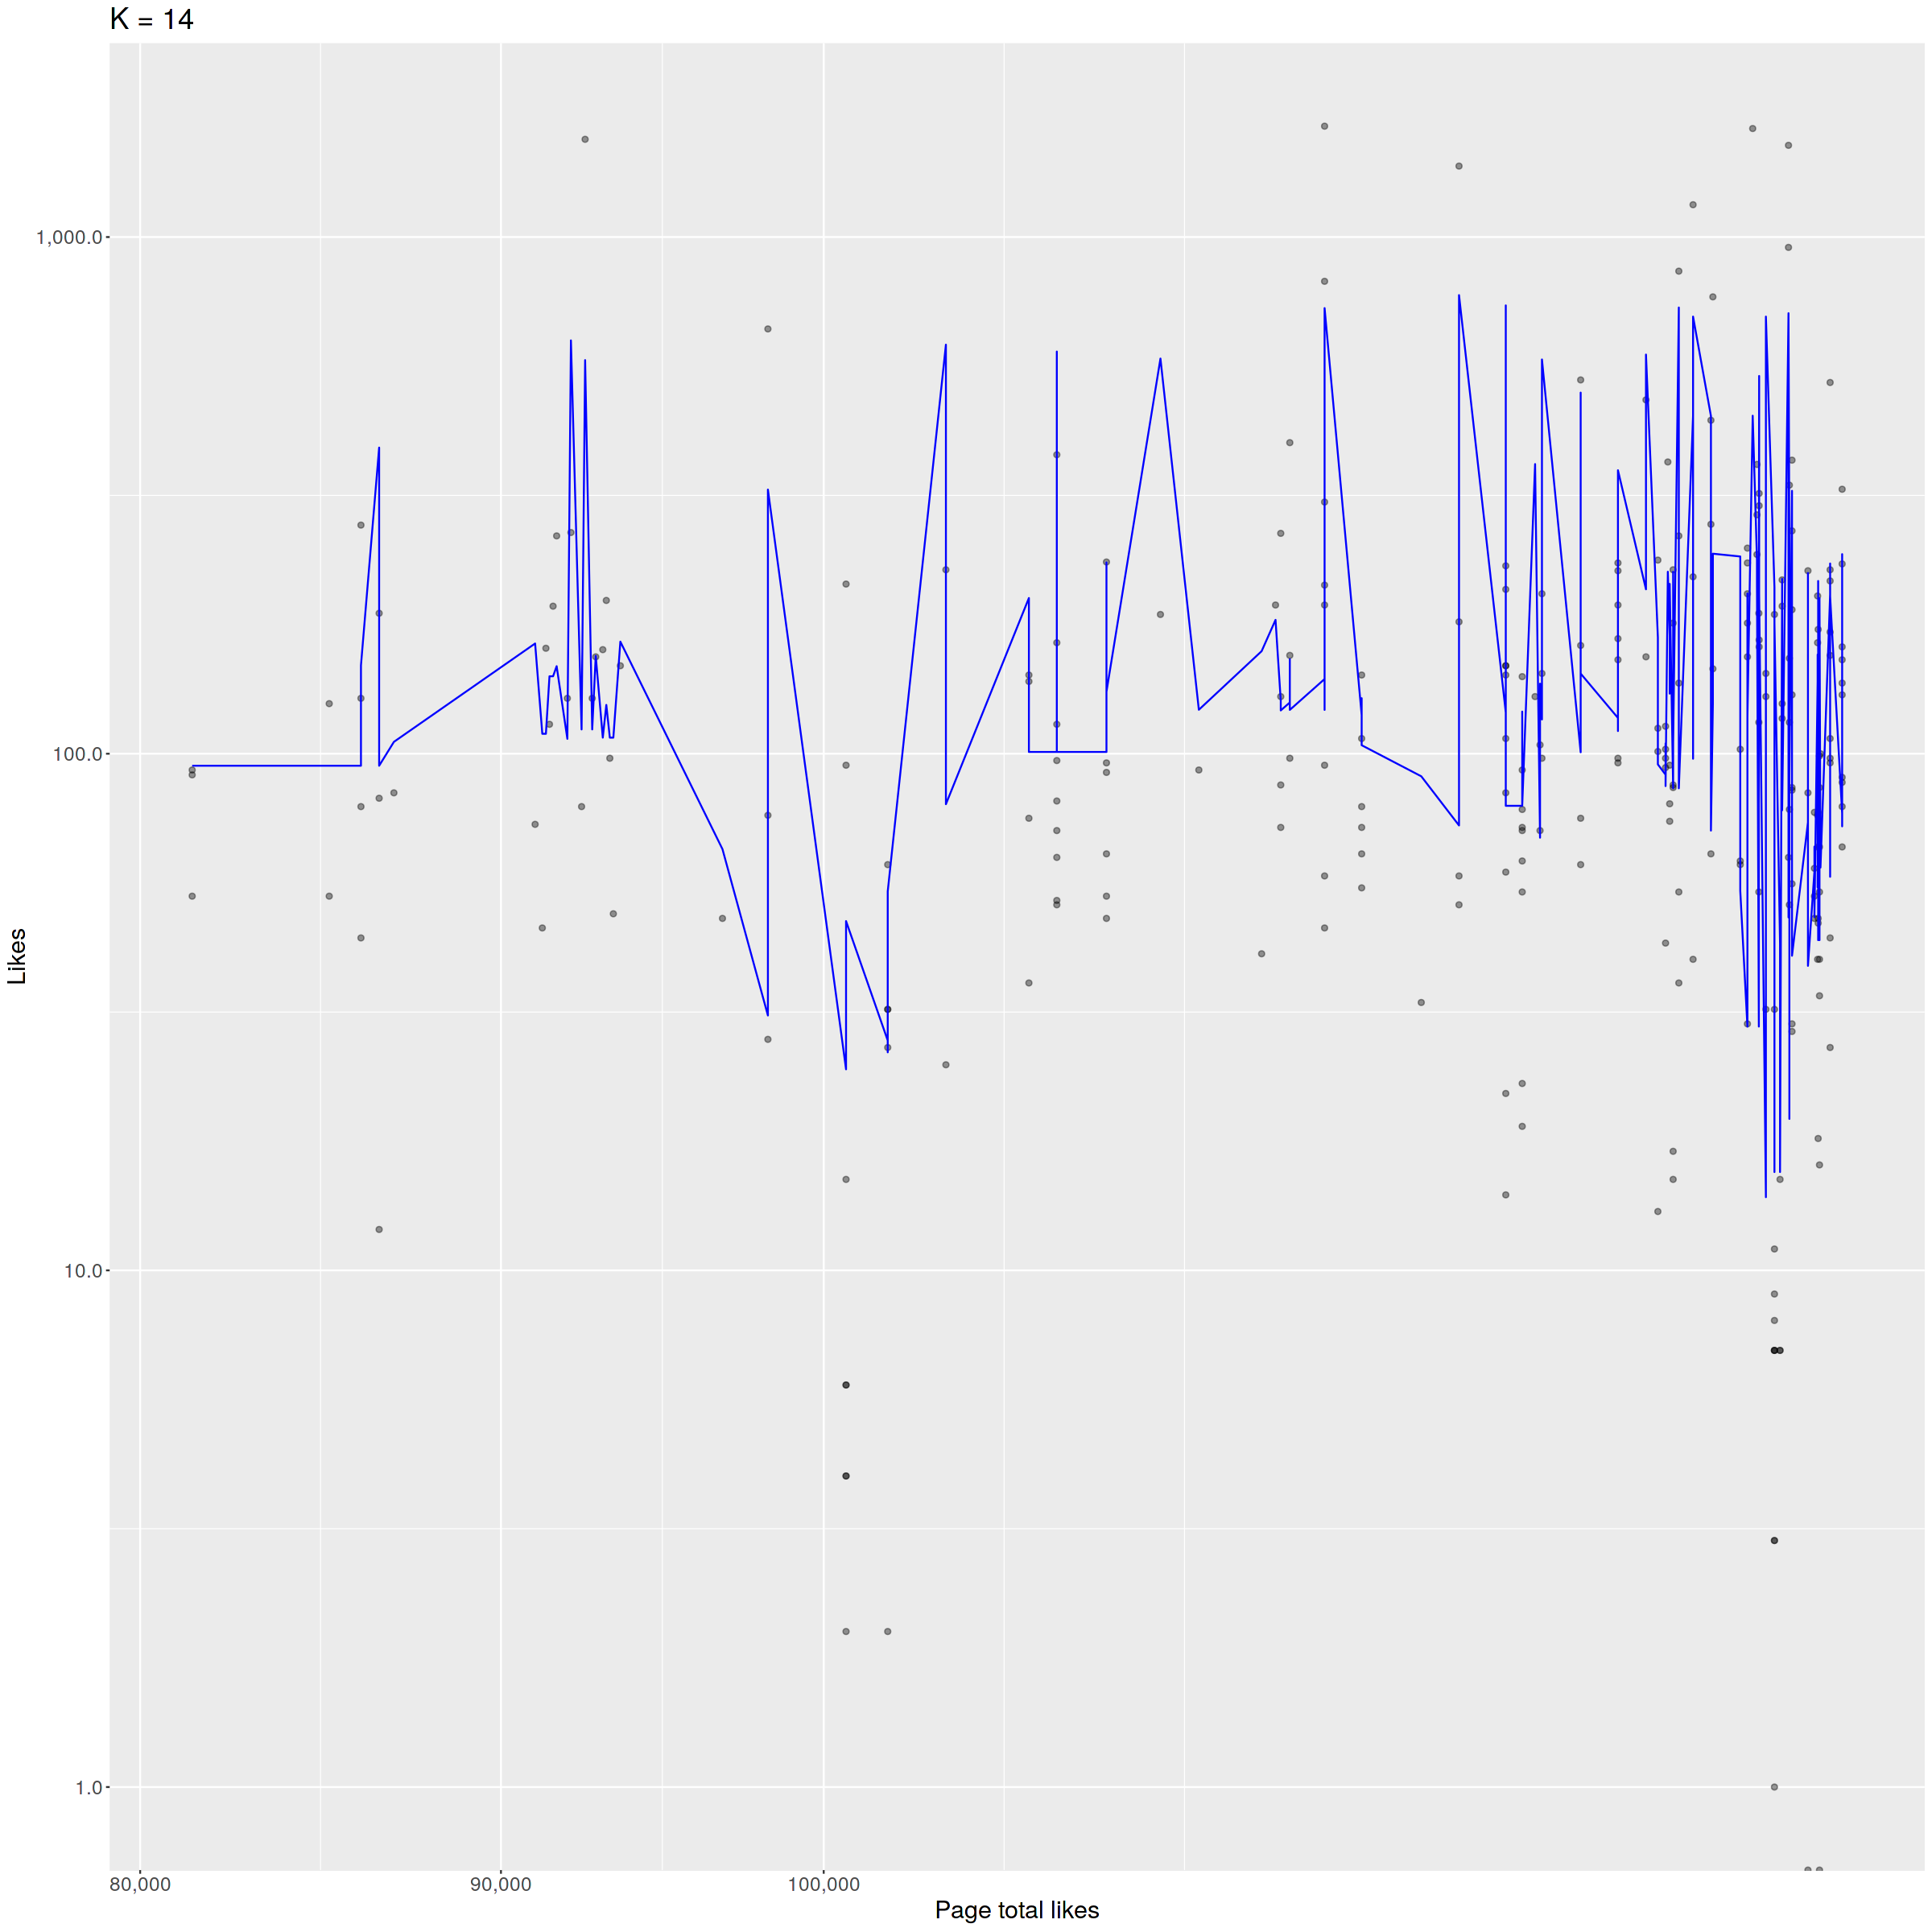

In [13]:
plot_knn <- ggplot(knn_preds, aes(x =  Lifetime.Post.Total.Reach, y = like)) +
  geom_point(alpha = 0.4) +
  xlab("Lifetime Post Total Reach") +
  ylab("Likes") +
  theme(text = element_text(size = 18)) +
  geom_line(data = knn_preds, aes(x = Lifetime.Post.Total.Reach, y = .pred), color = "blue") +
  ggtitle(paste0("K = ", kmin)) +
  scale_x_log10(labels = scales::comma) +
  scale_y_log10(labels = scales::comma)

plot_knn

plot_knn_1 <- ggplot(knn_preds, aes(x =  Lifetime.Post.Total.Impressions, y = like)) +
  geom_point(alpha = 0.4) +
  xlab("Lifetime Post Total Impressions") +
  ylab("Likes") +
  theme(text = element_text(size = 18)) +
  geom_line(data = knn_preds, aes(x = Lifetime.Post.Total.Impressions, y = .pred), color = "blue") +
  ggtitle(paste0("K = ", kmin)) +
  scale_x_log10(labels = scales::comma) +
  scale_y_log10(labels = scales::comma)

plot_knn_1

plot_knn_2 <- ggplot(knn_preds, aes(x =  Page.total.likes, y = like)) +
  geom_point(alpha = 0.4) +
  xlab("Page total likes") +
  ylab("Likes") +
  theme(text = element_text(size = 18)) +
  geom_line(data = knn_preds, aes(x = Page.total.likes, y = .pred), color = "blue") +
  ggtitle(paste0("K = ", kmin)) +
  scale_x_log10(labels = scales::comma) +
  scale_y_log10(labels = scales::comma)

plot_knn_2

**Linear Regression Model**

The linear regression model is created using similar steps as the k-nn model except the engine is set to “lm” for linear instead of k-nn for K-nearest neighbours. A new model specification and recipe is accordingly created. Using these, a workflow is made assigned to lm_fit which then creates the linear regression model. The workflow provides the coefficients for the predictors. The model is then tested and testing data collected using the testing data and metrics function. The test results provide the RMSPE value which is later used in the discussion.

In [14]:
lm_spec <- linear_reg() %>%
  set_engine("lm") %>%
  set_mode("regression")

lm_recipe <- recipe(like ~ Lifetime.Post.Consumers + Lifetime.Post.Total.Reach + Page.total.likes, data = analysis_select)

lm_fit <- workflow() %>%
  add_recipe(lm_recipe) %>%
  add_model(lm_spec) %>%
  fit(data = analysis_select)
lm_fit

lm_test_results <- lm_fit %>%
  predict(facebook_metrics_test) %>%
  bind_cols(facebook_metrics_test) %>%
  metrics(truth = like, estimate = .pred)
lm_test_results

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
              (Intercept)    Lifetime.Post.Consumers  
               -1.772e+02                  7.983e-02  
Lifetime.Post.Total.Reach           Page.total.likes  
                4.637e-03                  1.807e-03  


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,397.4385144
rsq,standard,0.3274897
mae,standard,130.6203893


The lm_plot is also a scatter graph of lifetime post total reach vs. likes however, the geom_smooth function has been used for the linear regression line to be overlaid over the scatter points. The alpha argument and the log10 scale are used for the same reason as the prior graphs.

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”


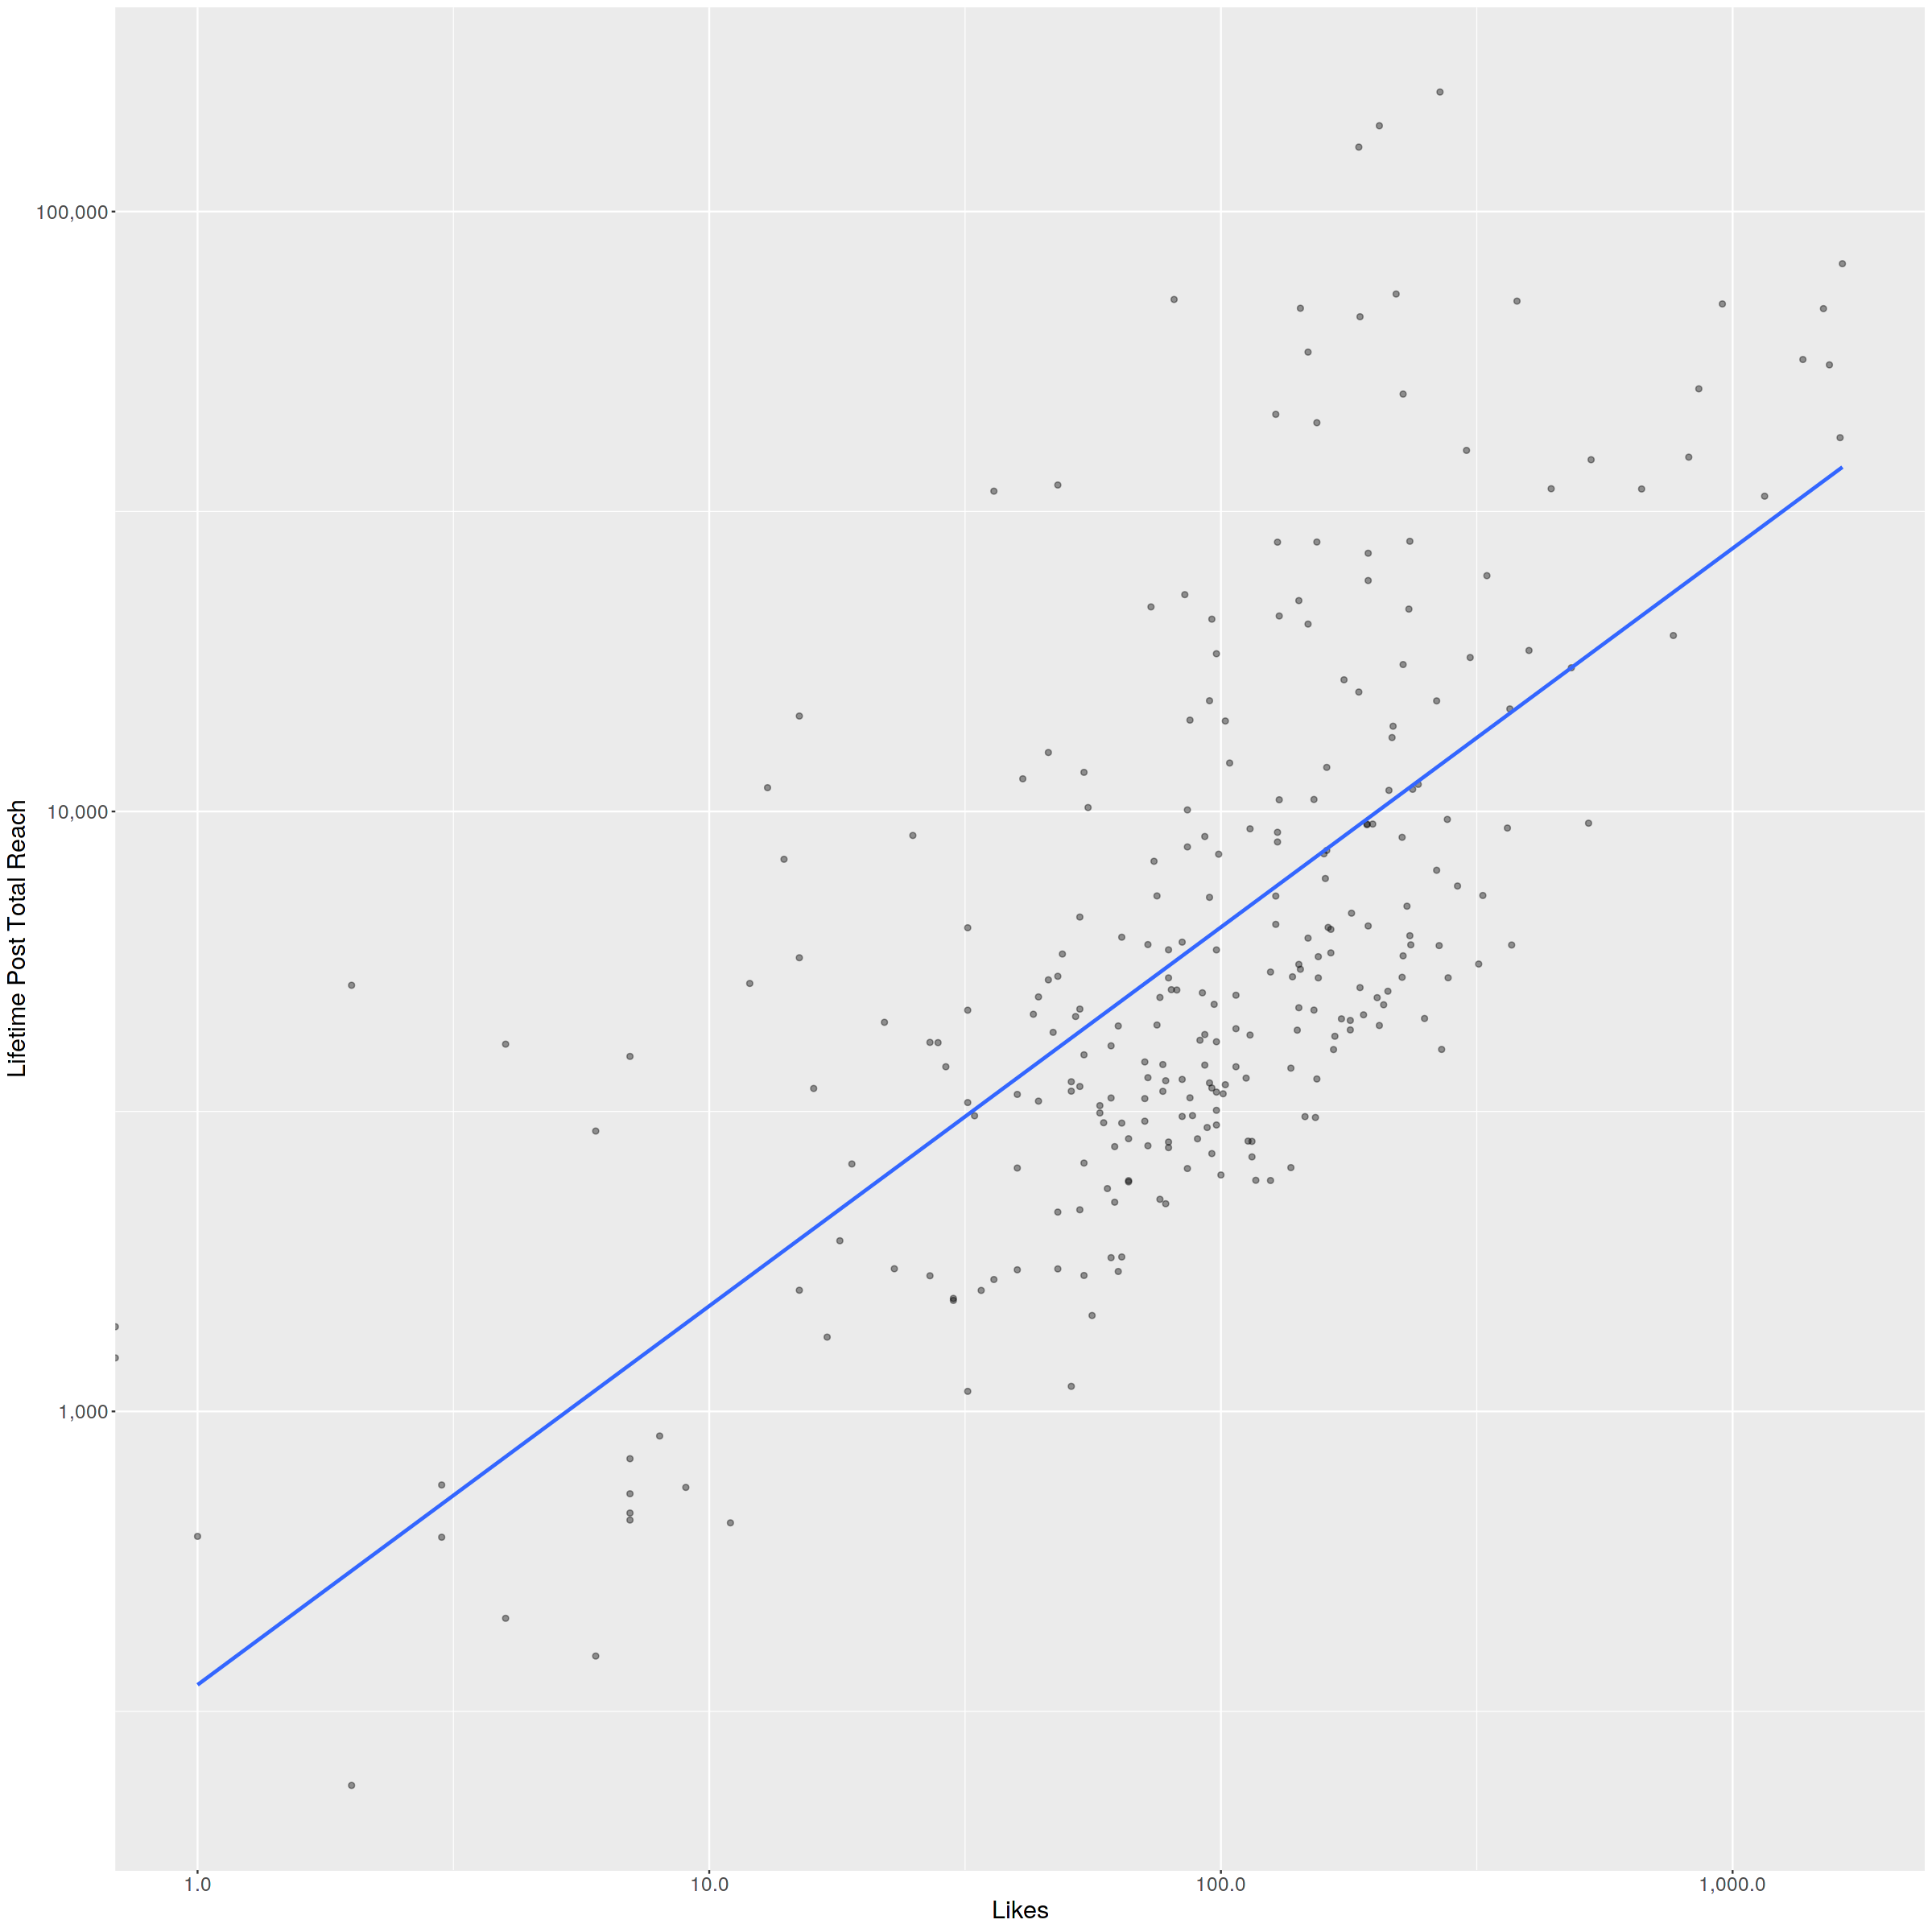

In [15]:
lm_plot_final <- ggplot(analysis_select, aes(x = like, y = Lifetime.Post.Total.Reach)) +
  geom_point(alpha = 0.4) +
  xlab("Likes") +
  ylab("Lifetime Post Total Reach") +
  theme(text = element_text(size = 18)) +
  geom_smooth(method = "lm", se = FALSE) +
  scale_x_log10(labels = scales::comma) +
  scale_y_log10(labels = scales::comma)

lm_plot_final

# Discussion

We were able to identify that a K-nearest neighbours regression model provided the less accurate model with the lowest Root Mean Squared Prediction Error (RMSPE) value of approximately 440.64 when tested using the training set initially created. The K-nn model used K=14 which was observed to be the best from the RMSE analysis after tuning. The corresponding visualization indicates that there is no significant underfitting or overfitting with some flattening at both ends of the regression model line. Flattening is caused due to the lack of nearest neighbours to extrapolate at either end of the data set.  

The linear regression model had a significantly lower RMSPE of approximately 382.49 when tested with the training set and had a linear line equation of 
> Likes = -154.3 + 6.029e-2 * Lifetime post consumers + 5.622e-3 * Lifetime post total reach + 1.670e-3 * Page total likes. 

Thus, the linear regression model is the more accurate model of the two.

The visualization indicated that the linear line identified the general trend of the points but the data does not have a very strong linear relationship. However, the linear regression line is observed to have a relatively even split of points above and below the line itself.

The RMSPE values of both of the models are much larger than initially expected from the models. Therefore, the models are both less accurate than anticipated. This may be due to there being a smaller range of likes than acceptable for a quantitative regression model.  However, the models are still less likely to be skewed by any one predictor and  maintain a general positive trend.

The k-nn model and the linear regression model both still have relatively high RMSPE’s as the range of likes is quite low from 5172 to 0 likes. Thus, an RMSPE of 382.49 likes indicates that there can potentially lead to an error as large as 382.49%. Additionally, the linear regression model is unexpectedly also more accurate than the k-nn regression model. Thus, due to the linear model being more accurate and better at extrapolation outside of the existing range of likes, it would be the chosen model from the two created.

The findings thus reveal that neither of the models have the required accuracy to appropriately predict the number of likes for a post based on the predictors Lifetime Post Total Reach, Lifetime Post Consumers, and Page total likes. This is likely caused by a combination of factors such as a lack of significant range between the highest number of likes and the lowest number of likes. Therefore, an RMSPE would likely be a much more significant error than when compared to the same RMSPE value for a dataset with a larger range. 

The model can be used to roughly predict a value of likes based on the chosen predictors, but it cannot be used to find a specific value. The cosmetics company could benefit from re-creating the same model once they begin to receive likes in the range of hundreds of thousands as the RMSPE could become less significant.

The models do indicate that similar code can be used to create like predicting models for larger companies or pages in order to predict the specific number of likes from the predictors alone. This leads to further questions regarding whether any specific predictors could be manipulated to increase the number of likes excluding whether the post is paid or not for this company in particular. Furthermore, as the predictors were chosen based on multicollinearity, would disregarding multicollinearity lead to an increased or decreased accuracy when creating an almost identical model? Supplementing this sort of research with a classification model for discrete values such as the category or type could also lead to increased control when creating posts for certain brands. Thus, data analyses and the use of statistics can be clearly observed to potentially maximize engagement for marketing of brands such as those of cosmetics.


# References

1. Edosomwan, S., Prakasan, S. K., Kouame, D., Watson, J., & Seymour, T. (2011). The history of social media and its impact on business. Journal of Applied Management and Entrepreneurship, 16(3), 79–91.
2. Insights, Digital (2014). Social Media 2014 Statistics. Retrieved September 10, 2015, from http://blog.digitalinsights.in/social-media-users-2014-stats-numbers 05205287.html
3. Moro, Sérgio; Rita, Paulo; Vala, Bernardo (2016). Predicting social media performance metrics and evaluation of the impact on brand building: A data mining approach. Journal of Business Research, (), S0148296316000813–. doi:10.1016/j.jbusres.2016.02.010
4. Wu, S. (2020). Multi-Collinearity in Regression. Medium. Retrieved 16 April 2021, from https://towardsdatascience.com/multi-collinearity-in-regression-       fe7a2c1467ea.
